# Wasserstein distance를 구현적 관점에서 알아보기

이름부터 무시무시한 Wassertstein distance. 이름만 무서우면 다행이지만 이 녀석의 정의 또한 무섭다. 
Wasserstein distance는 두 확률 분포 사이의 거리를 측정할 때 사용된다.
그런데 우리가 실제로 갖고 있는 것은 어느 확률 분포에서 샘플링된지 모르는 데이터셋이며, 두 데이터셋 사이의 Wasserstein distance를 구하는 것이 목표이다.
이번 포스팅에서는 확률 분포가 아닌 두 데이터셋이 주어졌을 때 Wasserstein distance를 계산하는 방법에 대해서 알아본다.

포스팅은 다음과 같이 구성되어 있다. 
먼저, Wasserstein distance의 정의를 살펴본다.
다음으로 1차원 데이터에 한정하여 정의에 해당하는 값을 해석적으로 구해볼 것이다. 
그리고 그 값을 코드로 구현하여 거리를 직접 계산해볼 것이다.

---


## $p$-Wasserstein distance의 정의

먼저, Wasserstein distance의 정의에 대해서 알아보자. 위키피디아의 정의를 그대로 따왔다. 

```{admonition} **$p$-Wasserstein distance**
:class: tip

Let $(\mathcal{X},d)$ be a metric space that is a Radon space, and let $p \in [1, \infty)$. For any two marginal measures $\mu$ and $\nu$ on $\mathcal{X}$, the Wasserstein distance of order $p$ between $\mu$ and $\nu$ is given by

$$
W_p(\mu, \nu) =  \left( \inf\limits_{\gamma \in \Gamma (\mu, \nu)} \displaystyle\int_{\mathcal{X} \times \mathcal{X}} d(x, y)^p d\gamma(x,y) \right)^{1/p},
$$

where $\Gamma(\mu, \nu)$ is the set of all couplings of $\mu$ and $\nu$. A coupling $\gamma(\mu, \nu)$ is a joint probability measure on $\mathcal{X} \times \mathcal{X}$ whose marginals are $\mu$ and $\nu$, respectively.
```

<br>

위의 정의를 온전히 이해하기 위해서는 수학과 대학원 확률론 지식 또는 최소 대학원 해석학 지식이 필요하다. 물론 나는 없다.
그래도 공부한 것을 바탕으로 정의를 읽어보자면 다음과 같다 (어지러우면 다음으로 문단으로 넘어가도 좋다). 

- Wasserstein distance는 두 probability measure 뮤 $\mu$와 누 $\nu$에 대해서 정의되는 것이다. Probability measure란 각 사건에 확률을 부여하는 함수 또는 규칙이며, 그냥 probability distribution이라고 생각해도 좋다. 조금 더 과감히 말하면 probability density function 또는 probability mass function으로 생각해도 좋다.
- 두 Probability measure의 sample space에 있는 원소들을 짝짓는 모든 coupling $\gamma(\mu, \mu)$ 중에 $\displaystyle\int_{\mathcal{X} \times \mathcal{X}} d(x, y)^p d\gamma(x,y)$의 최소값을 찾으면 그것의 $\frac{1}{p}$ 제곱이 $p$-Wasserstein distance이다. 여기서 coupling을 joint distribution으로 이해해도 좋다. 
- Wasserstein distance의 정의를 Earth mover's distance (흙 옮기는 기계)나 optimal transport problem (최적 운송 문제) 관점으로 해석할 수 있다. 한 확률 분포에 있는 mass를 최소의 비용으로 다른 확률 분포로 운송하는 것이다. 한 확률 분포의 $x$ 위치에 있는 mass를 다른 확률 분포의 $y$ 위치로 옮길 때 발생하는 비용 $d(x, y)$의 기댓값이 최소로 되도록 coupling을 찾는 것이다.

<br>


1차원 sample space 가정 등 여러 가지를 가정하면, 다음과 같이 우리에게 익숙한 용어로 정의를 다시 적어줄 수 있다.

```{admonition} **$p$-Wasserstein distance**
:class: tip

For any two real-valued random variables $X$ and $Y$, with probability density functions $f_X$ and $f_Y$, the Wasserstein distance between $X$ and $Y$ is given by

$$
    W_p(X, Y) =  \left( \inf\limits_{f_{XY} \in \mathcal{F}} \displaystyle\int_{\mathbb{R}}\int_{\mathbb{R}} f_{XY}(x, y) |x-y|^p \, dx \, dy \right)^{1/p},
$$

where $\mathcal{F}$ is the set of all joint probability of $X$ and $Y$ with marginal distributions $f_X$ and $f_Y$.
```

확률 용어에 익숙한 분들이라면 위 단순화된 정의는 쉽게 이해될 것이다. 
확률 변수 $X$와 $Y$에 대한 모든 가능한 joint distribution $f_{XY}$에 대해서 $\displaystyle\int_{\mathbb{R}}\int_{\mathbb{R}} f_{XY}(x, y) |x-y|^p \, dx \, dy$의 최소값을 찾는 것이다. 이 적분을 자세히 보면, 확률 변수 $|X-Y|^p$의 기댓값 $\mathbb{E}_{XY}\left[ |x-y|^p \right]$인 것을 알 수 있다.

---

## 1차원 데이터일 때 정의에 대한 analytic solution

정의에 따라 Wasserstein distance를 계산한다면 이 세상의 모든 joint distribution $f_{XY}(x, y)$에 대해서 $\mathbb{E}_{XY}\left[ |x-y|^p \right]$을 계산해보고 그 중 최소값을 구하는 최적화 문제를 풀어야 할 것이다. 너무나도 당연하게 많은 경우 이 행위는 intractable할 것이다. 근데 정말 다행히도 1차원 확률 변수 $X$와 $Y$에 대해서는 정의의 infimum 값이 해석적으로 계산되어 있다. 다음 statement를 보자.


```{admonition} **$p$-Wasserstein distance**
:class: tip

For any two real-valued random variables $X$ and $Y$, with cumulative distribution functions $F_X$ and $F_Y$, the Wasserstein distance between $X$ and $Y$ is given by

$$
    W_p(X, Y) = \left(\displaystyle\int_0^1 |F_X^{-1}(q) - F_Y^{-1}(q)| \, dq\right)^{1/p},
$$ (analytic-solution)

where $F_X^{-1}$ and $F_Y^{-1}$ are the quantile functions (inverse CDFs).
```

<br>

더 이상 infimum을 구할 필요 없이 각 확률 변수의 CDF의 역함수 $F_X^{-1}(q)$와 $F_Y^{-1}(q)$를 구해서 0부터 1까지 $|F_X^{-1}(q) - F_Y^{-1}(q)|$를 적분해주면 된다.
여전히 적분 연산이 필요하지만, 더 이상 최적화 문제를 풀지 않아도 된다. 
한 가지 더 좋은 점은 inverse CDFs의 차이를 0부터 1까지 적분하는 것이 그냥 CDFs의 차이를 정의역에 대해서 적분하는 것과 동일하다. 따라서 CDF만 찾아주면 된다 (아래 그림 참조, 출처 [2]).

![../img/cdfs2.png](../img/cdfs2.png)

<br>

```{note}
참고로 CDF $F_X: \mathbb{R} \rightarrow [0, 1]$는 정의역이 증가함에 따라 함수값이 0에서 1까지 증가하는 단조 증가 함수이지만 역함수가 없을 수 있다. 
정의역의 특정 구간에서 사건이 발생하지 않는다면 해당 구간에서 CDF의 값이 유지되기 때문에 일대일대응이 깨지기 때문이다.
그래서 우리는 CDF의 역함수를 일반적인 역함수와 다르게 다음과 같이 정의한다.

The general quantile function $F_X^{-1}: [0,1] \rightarrow \mathbb{R} $ (or general inverse CDF) is defined by

$$F_X^{-1}(p)=\inf \left\{ x \in \mathbb{R}: F_X(x) \ge p \right\}.$$

쉽게 말하면, CDF 값이 유지되는 구간에서는 가장 맨처음 값을 역함수 값으로 설정하겠다는 것이다.
```

Wasserstein distance 정의의 analytic solution이 식 {eq}`analytic-solution`이 되는 것에 대한 증명은 이 글 가장 마지막에 남겨 놓을 예정이다.

식 {eq}`analytic-solution` 덕분에 1차원 데이터에 대해서는 CDF를 찾아서 적분만 해주면 되게 된다...! 문제가 훨씬 쉬워졌지만,
여전히 실제 데이터에 대해 Wasserstein distance를 계산하기에는 다음 2가지 문제점이 있다.
- 우리가 갖고 있는 것은 확률 분포가 아니라 데이터인데 어떻게 CDF를 찾아야 할까?
- CDF를 찾았다고 해도 적분은 어떻게 할까?

---


## Wasserstein distance 구현하기

먼저, 우리가 갖고 있는 데이터의 CDF를 찾는 것은 쉽다. 우리는 흔히 데이터의 분포를 보기 위해 histogram을 그려본다. 이 histogram을 데이터의 확률 분포로 보는 것이다.
데이터가 있는 부분에 상대빈도수만큼 확률을 부여하는 measure를 empirical measure라고 부른다. 직관적으로도 이해가 되기 때문에 정의를 알 필요는 없지만, 굳이 적어보면 다음과 같다.

```{admonition} **Empirical measure**
:class: tip

Let $X_1, X_2, \ldots, X_n$ be a sequence of independent identically distributed real-valued random variables with probability distribution $P$. The empirical measure $P_n$ is defined by 

$$P_n(A) = {1 \over n} \sum_{i=1}^n \delta_{X_i}(A),$$

where $\delta_X$ is the Dirac measure.
```

<br>

그럼, 주어진 1차원 데이터들의 CDF는 어떻게 계산할까? 그냥 데이터를 오름차순으로 정렬하고, 순서대로 상대빈도수를 계속 더해나가면 된다. 이쯤에서 코드 구현에 사용할 예제 데이터를 보자. x는 0, 2, 4, 6, 10에 노이즈를 추가한 것이고, y는 1, 3, 5, 7, 9에 노이즈를 추가한 것이다. 그리고 순서를 뒤죽박죽 섞어주었다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

np.set_printoptions(precision=2)

x = np.array([0.0, 2.0, 4.0, 6.0, 8.0, 10.0]) + np.random.rand(6)
y = np.array([1.0, 3.0, 5.0, 7.0, 9.0]) + np.random.rand(5)

np.random.shuffle(x)
np.random.shuffle(y)

print(x)
print(y)

[10.65  4.6   6.54  8.42  2.72  0.55]
[5.96 7.38 9.79 3.89 1.44]


<br>

`x`와 `y`에 대한 CDF를 구하는 방법은 굉장히 쉽다. 먼저 정렬하고, 순서대로 $\frac{1}{\text{데이터 개수}}=\frac{1}{6}$을 더해주면 된다.

In [2]:
x_sorted = np.sort(x)
cum_x = (np.arange(len(x)) + 1) / len(x)

print(x_sorted)
print(cum_x)

[ 0.55  2.72  4.6   6.54  8.42 10.65]
[0.17 0.33 0.5  0.67 0.83 1.  ]


In [3]:
y_sorted = np.sort(y)
cum_y = (np.arange(len(y)) + 1) / len(y)

print(y_sorted)
print(cum_y)

[1.44 3.89 5.96 7.38 9.79]
[0.2 0.4 0.6 0.8 1. ]


<br>

아직 끝난 것은 아니다. 우리가 갖고 있는 것은 여전히 $(x, F_X(x))$, $(y, F_X(y))$ "데이터"이고, 진짜 CDF은 아니다.
CDF는 정의역의 모든 값에 대해 정의가 되는 반면 우리는 각 데이터에 대해서 CDF 값만 갖고 있을 뿐이다. 그림을 그려보면 다음과 같다.

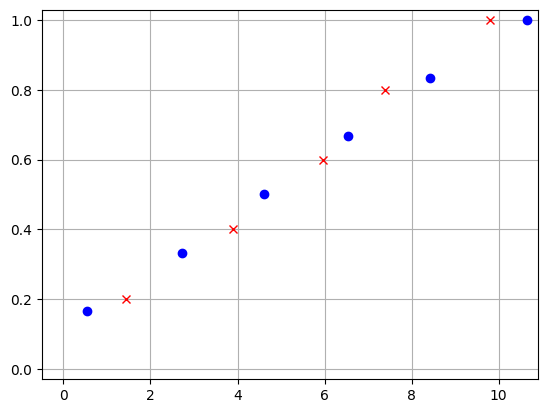

In [4]:
plt.figure()
plt.plot(x_sorted, cum_x, 'bo')
plt.plot(y_sorted, cum_y, 'rx')
plt.grid()
plt.xlim(-0.5, 10.9)
plt.ylim(-0.03, 1.03)
plt.show()

<br>

하지만 우리가 원하는 CDF는 다음 그림과 같다.


```{image} ../img/cdfs.png
:alt: cdfs
:width: 400px
:align: center
```



<br>

우리의 목표는 두 CDF 사이의 차이가 발생하는 영역의 넓이를 계산하는 것이다. 
그런데 위 그림을 보니, 영역들이 모두 사각형인 것을 확인할 수 있다.

- 데이터가 주어질 경우, CDF 사이의 차이가 발생하는 영역은 사각형이다. <br>
- 사각형의 넓이를 더 쉽게 구하기 위해서는 `x` 데이터와 `y` 데이터를 모두 합쳐서 보는 것이 좋다.<br>
- 사각형의 가로 길이는 `all_values[i+1] - all_values[i]`로 쉽게 구할 수 있다.
  
먼저 `x`와 `y`를 합쳐놓자.

In [5]:
all_values = np.concatenate((x, y))
all_values.sort()
print(all_values)

[ 0.55  1.44  2.72  3.89  4.6   5.96  6.54  7.38  8.42  9.79 10.65]


<br>

각 사각형의 가로 길이는 `np.diff()` 함수를 통해서 쉽게 구할 수 있다.

In [6]:
deltas = np.diff(all_values)
deltas

array([0.89, 1.28, 1.18, 0.71, 1.36, 0.58, 0.84, 1.04, 1.37, 0.85])

<br>

하지만, 이렇게 되면 어떤 점이 `x`에서 왔는지 `y`에서 왔는지 모른다. `a.searchsorted(v)` 메서드는 `v` 배열의 각 원소가 정렬되어 있는 `a` 배열에서 크기 순서상 어느 인덱스에 위치해야 하는지 알려준다. 즉, 아래 코드에서 `x_cdf_indices`는 `all_values` 배열의 각 값이 `x_sorted` 배열에서 어디에 위치해야 하는지 적어놓은 배열이다.
`all_values`에서 `x` 배열에서 온 데이터를 마주칠 때마다 +1을 해준 배열이 된다.

In [7]:
x_cdf_indices = x_sorted.searchsorted(all_values[:-1], 'right')
x_cdf_indices

array([1, 1, 2, 2, 3, 3, 4, 4, 5, 5])

In [8]:
y_cdf_indices = y_sorted.searchsorted(all_values[:-1], 'right')
y_cdf_indices

array([0, 1, 1, 2, 2, 3, 3, 4, 4, 5])

<br>

CDF는 다음과 같이 구할 수 있다.

In [9]:
x_cdf = x_cdf_indices / len(x)
y_cdf = y_cdf_indices / len(y)

print(all_values[:-1])
print(x_cdf)
print(y_cdf)

[0.55 1.44 2.72 3.89 4.6  5.96 6.54 7.38 8.42 9.79]
[0.17 0.17 0.33 0.33 0.5  0.5  0.67 0.67 0.83 0.83]
[0.  0.2 0.2 0.4 0.4 0.6 0.6 0.8 0.8 1. ]


<br>

계산한 가로 길이 (`deltas`)와 CDFs (`x_cdf`, `y_cdf`)를 사용해서 $p$-Wasserstein distance를 계산해보면 다음과 같다.

In [10]:
p = 1
if p == 1:
    d = np.sum(np.multiply(np.abs(x_cdf - y_cdf), deltas))
elif p == 2:
    d = np.sqrt(np.sum(np.multiply(np.square(x_cdf - y_cdf), deltas)))
else: 
    d = np.power(np.sum(np.multiply(np.power(np.abs(x_cdf - y_cdf), p),
                                       deltas)), 1/p)
print(d)

0.9717676936051363


<br>

지금까지의 과정을 모두 합쳐서 함수로 만들어 보면 다음과 같다. 이는 실제로 SciPy에 있는 `wasserstein_distance` 함수의 간략화된 버전이다.

In [11]:
def _cdf_distance(p, x, y):
    """
    From https://github.com/scipy/scipy/blob/v1.10.1/scipy/stats/_stats_py.py#L9165
    """
    x_sorted = np.sort(x)
    y_sorted = np.sort(y)
    
    all_values = np.concatenate((x, y))
    all_values.sort(kind='mergesort')

    # Compute the differences between pairs of successive values of u and v.
    deltas = np.diff(all_values)

    # Get the respective positions of the values of u and v among the values of
    # both distributions.
    x_cdf_indices = x_sorted.searchsorted(all_values[:-1], 'right')
    y_cdf_indices = y_sorted.searchsorted(all_values[:-1], 'right')

    # Calculate the CDFs of u and v using their weights, if specified.
    x_cdf = x_cdf_indices / x.size
    y_cdf = y_cdf_indices / y.size

    # Compute the value of the integral based on the CDFs.
    # If p = 1 or p = 2, we avoid using np.power, which introduces an overhead
    # of about 15%.
    if p == 1:
        return np.sum(np.multiply(np.abs(x_cdf - y_cdf), deltas))
    if p == 2:
        return np.sqrt(np.sum(np.multiply(np.square(x_cdf - y_cdf), deltas)))
    return np.power(np.sum(np.multiply(np.power(np.abs(x_cdf - y_cdf), p),
                                       deltas)), 1/p)


In [12]:
from scipy.stats import wasserstein_distance

print(wasserstein_distance(x, y))

0.9717676936051363


<br>

이번 포스팅에서는 1차원 데이터에 대해서 두 데이터셋의 $p$-Wasserstein distance이 어떻게 계산되는지 직접 구현해보았다.
두 확률 분포에 대해서 기대 비용의 최소값으로 정의되어 있는 반면, 우리는 두 데이터셋 사이의 거리를 구하고 싶은 것이기 때문에 도저히 어떻게 구현되는지 감이 오지 않았다.
이번 포스팅을 통해서 그나마 1차원 데이터에 대해서 Wasserstein distance가 구현되는지 알 수 있게 되었다.

1차원을 넘어 고차원에 대해서도 어떻게 구현되는지 알아보았는데, 실제로 최적화 문제를 풀게 된다. 
한 데이터셋 $X$의 각 데이터 $x$를 다른 데이터셋 $Y$의 각 데이터 $y$로 매핑하는 모든 경우의 수에 대해서 $\lVert x - y \rVert_p$의 최솟값을 구하는 문제를 풀게 된다.
기회가 된다면 고차원에 대해서도 정리를 해보도록 하겠다.


## 식 {eq}`analytic-solution` 증명
Coming soon!

---

<br>

## 참고문헌
[1] [https://en.wikipedia.org/wiki/Wasserstein_metric](https://en.wikipedia.org/wiki/Wasserstein_metric)

[2] Marc G. Bellemare and Will Dabney and Mark Rowland, Distributional Reinforcement Learning
, MIT Press, 2022. [https://www.distributional-rl.org/contents/chapter4.html](https://www.distributional-rl.org/contents/chapter4.html)

[3] Ramdas A, Trillos NG, Cuturi M. On Wasserstein Two-Sample Testing and Related Families of Nonparametric Tests. Entropy. 2017; 19(2):47. https://doi.org/10.3390/e19020047